In [3]:
%%capture
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U

In [4]:
import torch

2.0.1+cu118


In [5]:
from transformers import AutoImageProcessor, BeitForImageClassification, BeitModel
from transformers import (Trainer,TrainingArguments,AutoTokenizer,default_data_collator)
import torch
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [6]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/beit-base-patch16-224")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [7]:
dataset = load_dataset("dataset")

Resolving data files:   0%|          | 0/7951 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1990 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/500 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [10]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/beit-base-patch16-224")

# preprocess function
def preprocess_function(examples):
    return image_processor(examples["image"],return_tensors="pt")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [11]:
dataset_test = dataset['test'].map(preprocess_function,batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [18]:
dataset_test = dataset_test.remove_columns(["image"])

In [44]:
num_labels = len(dataset_test.unique("label"))
# model = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224", ignore_mismatched_sizes=True, num_labels=num_labels)
model = BeitForImageClassification.from_pretrained("./HPO_Augmentation")

In [45]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="micro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [46]:
dataset_test

Dataset({
    features: ['label', 'pixel_values'],
    num_rows: 500
})

In [49]:
training_args = TrainingArguments(
        output_dir="beit_model",
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_ratio=0.1,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir="beit_model/logs",
        learning_rate=5e-5,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
    )

In [50]:
from transformers import AutoImageProcessor, BeitForImageClassification
import torch

In [51]:
trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=dataset_test,
        eval_dataset=dataset_test,
        data_collator=default_data_collator,
    )

In [52]:
out = trainer.predict(dataset_test)

In [53]:
labels = out.label_ids

In [55]:
import numpy as np

predictions = np.argmax(out.predictions, axis = 1)

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [58]:
cm = confusion_matrix(labels, predictions)

In [59]:
from sklearn.metrics import classification_report
# Calculate the classification report
class_report = classification_report(labels, predictions, target_names=['1 Object', '2 Objects', '3 Objects', '4 Objects', '5 Objects'])

# Print the classification report
print(class_report)


              precision    recall  f1-score   support

    1 Object       0.90      0.64      0.75       100
   2 Objects       0.42      0.45      0.44       100
   3 Objects       0.33      0.53      0.41       100
   4 Objects       0.34      0.34      0.34       100
   5 Objects       0.53      0.33      0.41       100

    accuracy                           0.46       500
   macro avg       0.51      0.46      0.47       500
weighted avg       0.51      0.46      0.47       500



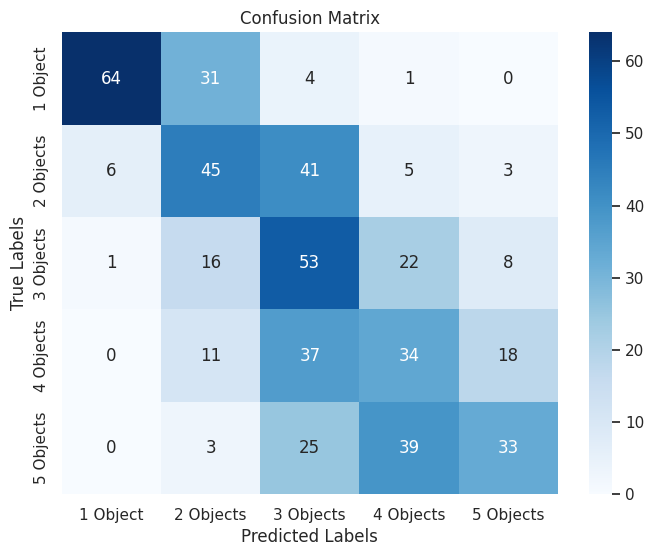

In [60]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.set()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Replace 'class_names' with the names of your 5 classes
class_names = ['1 Object', '2 Objects', '3 Objects', '4 Objects', '5 Objects']
plot_confusion_matrix(cm, class_names)
